# POLI 175 - Lecture 17

## Non-linearity II

## Some new data

- Countries dataset: 
    + Let us create a model to predict the **proportion of seats held by women in the national parliament** (`wdi_wip`).
    
- Explanatory variables I propose ([you can find others here](https://www.qogdata.pol.gu.se/data/bas_codebook_jan23.pdf)):

1. (`pwt_pop`) Population
2. (`wdi_expedu`) Expenditure on education (% of GDP)
3. (`mad_gdppc`) Real GDP per capita

In [1]:
## Loading the relevant packages
import pandas as pd
import numpy as np

# Plotting things:
import seaborn as sns
import matplotlib.pyplot as plt

# Look at our friend here to help with GAM
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

# Loading scikit learn relevant packages (note our new friends!)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, get_scorer_names, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
## Countries Dataset
countr = pd.read_csv('https://raw.githubusercontent.com/umbertomig/POLI175public/main/data/countrdat.csv')
countr.head()

,ccodealp,year,cname,wdi_wip,pwt_pop,wdi_expedu,mad_gdppc
0,ALB,1999,Albania,5.161290,3.122697,3.59293,4432.0426
1,ALB,2000,Albania,5.161290,3.129243,3.43017,4808.4796
2,ALB,2001,Albania,5.714286,3.129704,3.45870,5285.8091
3,ALB,2002,Albania,5.714286,3.126187,3.11780,5608.9623
4,ALB,2003,Albania,5.714286,3.118023,3.13823,6004.6452


In [3]:
## Education Expenditure Dataset
educ = pd.read_csv('https://raw.githubusercontent.com/umbertomig/POLI175public/main/data/educexp.csv')
educ = educ[['education', 'income']]
educ.head()

,education,income
0,189,2824
1,169,3259
2,230,3072
3,168,3835
4,180,3549


## Piecewise-constant Regression

- Here, we would be breaks in the predictor, making it an ordered categorical variable instead of a continuous variable.

- Let a variable $X$, the indicator function $I(.)$, and a set of cutpoints $\{c_1, c_2, \cdots, c_k\}$. The stepped variable $X$, $C_j(X)$, becomes:

$$
\begin{align}
C_{0}(X) &= I(X < c_1) \\
C_{1}(X) &= I(c_1 \leq X < c_2) \\
C_{2}(X) &= I(c_2 \leq X < c_3) \\
&\vdots\\
C_{K-1}(X) &= I(c_{K-1} \leq X < c_K) \\
C_{K}(X) &= I(X \geq c_K)
\end{align}
$$

## Piecewise-constant Regression

- Example use: when age is defined in 5-years bins.

- Detail: $C_0(x_i) + C_1(x_i) + \cdots + C_K(x_i) = 1$. This would make adding all pieces impossible:
    + Perfect Collinearity.

- The regression model becomes:

$$ y_i = \beta_0 + \beta_1C_1(x_i) + \beta_2C_2(x_i) +\cdots + \beta_KC_K(x_i) + \varepsilon_i $$

## Piecewise-constant Regression

![img](../img/pcreg1.png)

## Piecewise-constant Regression

In [4]:
## Piecewise-constant Regression
y = educ[['education']]
X = educ[['income']]
X = pd.cut(X.income, bins = [0, 2500, 3000, 3200, 3500, 4000, 5000])
X = pd.get_dummies(X, drop_first = True)
reg = LinearRegression().fit(X, y)
print('The MSE for this piecewise constant regression is: ' + str(np.mean((reg.predict(X) - y) ** 2, axis=0)))

The MSE for this piecewise constant regression is: education    1138.544481
dtype: float64


In [5]:
## With cross-validation now
poly = PolynomialFeatures(degree = 4)
X = educ[['income']]
X = pd.cut(X.income, bins = [0, 2500, 3000, 3200, 3500, 4000, 5000])
X = pd.get_dummies(X, drop_first = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 12345)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)
reg = LinearRegression().fit(X_train, y_train)
print('The CV-MSE for this piecewise constant regression is: ' + str(np.mean((reg.predict(X_test) - y_test) ** 2, axis=0)))

The CV-MSE for this piecewise constant regression is: education    1241.692308
dtype: float64


# Non-Linearity

- So far, we have seen polynomial regression and constant-piecewise regression.

- Now let us study:
    + Splines and Smoothing Splines
    + GAMs

In [6]:
## Process dataset
y = countr['wdi_wip']
X = countr[['year', 'pwt_pop', 'wdi_expedu', 'mad_gdppc']]
X_zed = StandardScaler().set_output(transform = 'pandas').fit_transform(X)
X_zed.head()

,year,pwt_pop,wdi_expedu,mad_gdppc
0,-1.671402,-0.267807,-0.450176,-0.691774
1,-1.505236,-0.267764,-0.547556,-0.670224
2,-1.339071,-0.267761,-0.530486,-0.642898
3,-1.172905,-0.267784,-0.734450,-0.624399
4,-1.006740,-0.267838,-0.722226,-0.601747


In [7]:
## Splines with five knots in all variables
splines = SplineTransformer(n_knots = 5, 
                            degree = 3, 
                            knots = 'quantile',
                            extrapolation = 'constant')

X_full = splines.set_output(transform = 'pandas').fit_transform(X_zed)
cv = KFold(n_splits=5, shuffle=True)
reg = LinearRegression()
r2s = cross_val_score(reg, X_full, y, 
                      scoring = 'r2',
                      cv = cv, n_jobs = -1)
print('The Cross-Validated R-squared for this regression is: ' + str(np.mean(r2s)))

The Cross-Validated R-squared for this regression is: 0.3150448625909027


## Basis Functions

- Family of transformations $b_i(X)$ such that, instead of fitting a regression model in $X$, we fit:

$$ y_i \ = \ \beta_0 + \beta_1b_1(x_i) + \beta_2b_2(x_i) + \cdots + \beta_kb_k(x_i) + \varepsilon_i $$

- In this sense:
    - Polynomial Regression: $b_j(x_i) = x_i^j$
    - Constant-piecewise Regression: $b_j(x_i) = C_j(x_i) = I(c_j \leq X < c_{j+1})$
    
- Meaning: they are cases of a broader set of basis functions.

## Basis Functions

- Other cases:
    + [Fourier series](https://en.wikipedia.org/wiki/Fourier_series)
    + [Splines](https://en.wikipedia.org/wiki/Spline_(mathematics))
    + [GAMs](https://en.wikipedia.org/wiki/Generalized_additive_model)
    
- We are going to study Splines and GAMs here.

## Splines

- Suppose we want to fit a cubic polynomial. We can use the least square method very effectively for this case:

$$ y_i = \beta_0 + \beta_1x_i + \beta_2x_i^2 + \beta_3x_i^3 + \varepsilon_i $$

- Very straightforward: use OLS and done!

## Splines

- Now, suppose that we want this polynomial to change its curvature for different parts of the data.

- We may want to fit a particular polynomial in one-half of the data and a different one in the other part of the data.

## Splines

- Let $x = c$ the threshold (we call it *knot*). Then:

$$ y_i = \left\{\begin{align}
        \beta_{01} + \beta_{11}x_i + \beta_{21}x_i^2 + \beta_{31}x_i^3 + \varepsilon_i & \ \ \text{ if } x_i < c\\
        \beta_{02} + \beta_{12}x_i + \beta_{22}x_i^2 + \beta_{32}x_i^3 + \varepsilon_i & \ \ \text{ if } x_i \geq c
        \end{align} \right. $$
        
- And thus, we would fit eight coefficients. Four for each piece. If we add $K$ knots, we would fit $K+1$ polynomials.

- The more knots, the more flexible the polynomial becomes.

- Piecewise-constant: The degree of the polynomial is zero.

## Splines

- The problem with fitting splines is that we need to add constraints. Example:

![img](../img/spl1.png)

## Splines

- We want our polynomials to be smooth. This needs us to add constraints on the end-points and the derivatives at these points.

- End-points should meet. Derivatives should be the same at the knot (added smoothness).

- Let this be the basis function:

$$ y_i \ = \ \beta_0 + \beta_1b_1(x_i) + \beta_2b_2(x_i) + \cdots + \beta_kb_k(x_i) + \varepsilon_i $$

- What are the $b$'s that would make this a cubic spline with all continuous derivatives?

## Splines

- To achieve the smoothness on a cubic spline with a knot in $\xi$, we can use the basis function:

$$ 
h(x, \xi) \ = \ (x-\xi)^3_+ \ = \ \left\{\begin{align}
        (x - \xi)^3 & \ \ \text{ if } x > \xi \\
        0 & \ \ \text{ otherwise }
        \end{align} \right.
$$

- And for a K-knots cubic spline: $b_0(X) = 1$, $b_1(X) = X$, $b_2(X) = X^2$, $b_3(X) = X^3$, $b_4(X) = h(X, \xi_1)$, $b_5(X) = h(X, \xi_2)$, $\cdots$ , $b_{K + 3}(X) = h(X, \xi_K)$.

- This spline uses $K + 4$ degress of freedom.

In [8]:
## Baseline: OLS
X_full = X_zed
cv = KFold(n_splits=10, shuffle=True)
reg = LinearRegression()
r2s = cross_val_score(reg, X_zed, y, 
                      scoring = 'r2',
                      cv = cv, n_jobs = -1)

print('The Cross-Validated R-squared for this regression is: ' + str(np.mean(r2s)))

The Cross-Validated R-squared for this regression is: 0.21901688849155515


In [9]:
## Splines with five knots for only year variable (very common control feature)
splines = SplineTransformer(n_knots = 5, 
                            degree = 3, 
                            knots = 'quantile',
                            extrapolation = 'constant')

year_splined = splines.set_output(transform = 'pandas').fit_transform(countr[['year']])
year_splined.head()

,year_sp_0,year_sp_1,year_sp_2,year_sp_3,year_sp_4,year_sp_5,year_sp_6
0,0.060739,0.579882,0.354209,0.005171,0.0,0.0,0.0
1,0.031098,0.501084,0.450365,0.017453,0.0,0.0,0.0
2,0.013120,0.408270,0.537240,0.041370,0.0,0.0,0.0
3,0.003887,0.310712,0.604599,0.080802,0.0,0.0,0.0
4,0.000486,0.217685,0.642204,0.139625,0.0,0.0,0.0


In [10]:
## Splines with five knots for only time variable (very common control feature)
X_full = year_splined.join(X_zed.drop('year', axis = 1))
cv = KFold(n_splits=5, shuffle=True)
reg = LinearRegression()
r2s = cross_val_score(reg, X_full, y, 
                      scoring = 'r2',
                      cv = cv, n_jobs = -1)

print('The Cross-Validated R-squared for this regression is: ' + str(np.mean(r2s)))

The Cross-Validated R-squared for this regression is: 0.21639915130533485


## Splines

- *Natural spline:* add the requirement to local-linear in the bounds (below the first knot and above the last knot).

![img](../img/natvscubspl1.png)

## Splines

- When we fit a spline, where should we place the knots?

- Usually, we choose a uniformly distributed amount of knots placed on the percentiles (e.g., Q1, Median, and Q3).

- To find a uniformly distributed amount of knots, one can use cross-validation:
    1. Fit a model with $K$ knots
    2. Look at the cross-validated RSS and change to $K+1$ or $K-1$, accordingly.

## Splines

![img](../img/natvscubspl2.png)

## Splines

- Natural Cubic Splines (15dfs) x degree-15 polynomial

![img](../img/ncubspl.png)

In [11]:
## Natural Splines
splines = SplineTransformer(n_knots = 5, 
                            degree = 3, 
                            knots = 'quantile',
                            extrapolation = 'linear')

X_full = splines.set_output(transform = 'pandas').fit_transform(X_zed)
cv = KFold(n_splits=5, shuffle=True)
reg = LinearRegression()
r2s = cross_val_score(reg, X_full, y, 
                      scoring = 'r2',
                      cv = cv, n_jobs = -1)
print('The Cross-Validated R-squared for this regression is: ' + str(np.mean(r2s)))

The Cross-Validated R-squared for this regression is: 0.3132722031720993


In [12]:
## Natural Splines: picking the best number of knots
meanr2 = []
knots = []
for i in range(2, 100):
    knots.append(i)
    splines = SplineTransformer(n_knots = i, degree = 3, 
                                knots = 'quantile', extrapolation = 'linear')
    X_full = splines.set_output(transform = 'pandas').fit_transform(X_zed)
    cv = KFold(n_splits = 10, shuffle = True)
    reg = LinearRegression()
    r2s = cross_val_score(reg, X_full, y, scoring = 'r2', cv = cv, n_jobs = -1)
    meanr2.append(np.mean(r2s))

print('Best number of knots is {a}.\nThe CV R-squared associated with it is {b}.'.format(a = str(knots[meanr2.index(max(meanr2))]), b = str(max(meanr2))))

Best number of knots is 34.
The CV R-squared associated with it is 0.35305063135627207.


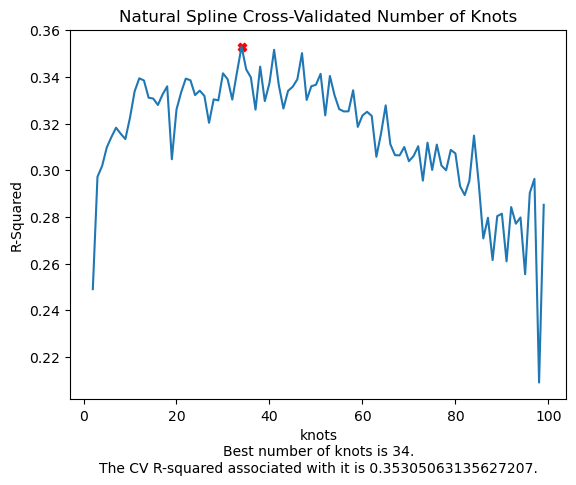

In [13]:
## Natural Splines: picking the best number of knots
sns.lineplot(x = knots, y = meanr2)
plt.title('Natural Spline Cross-Validated Number of Knots')
plt.xlabel('knots\n' + 'Best number of knots is {a}.\nThe CV R-squared associated with it is {b}.'.format(a = str(knots[meanr2.index(max(meanr2))]), b = str(max(meanr2))))
plt.ylabel('R-Squared')
plt.scatter(knots[meanr2.index(max(meanr2))], max(meanr2), marker='X', color = 'red')
plt.show()

## GAMs

- A different way to think about the problem is: Suppose we have $p$ variables. 

- Then, we could have a flexible function for each variable:

$$ y_i \ = \ \beta_0 + f_1(x_{i1}) + f_2(x_{i2}) + \cdots + f_p(x_{ip}) + \varepsilon_i $$

- This is called **Generalized Additive Models**, or **GAMs** for short.

## GAMs

- For each $f$, we can combine natural splines (continuous) and piecewise-constant functions (discrete).

- The book wage example summarizes this well. In here: $ \text{wage} = \beta_0 + f_1(\text{year}) + f_2(\text{age}) + f_3(\text{education}) + \varepsilon $

- $f_1$ and $f_2$ are natural splines; $f_3$ piecewise constant.

![img](../img/gam.png)

## GAMs

**Positives**:

- GAMs are *easy* to interpret: the interpretation of each pattern would be: holding other things constant, this is how $x_j$ affects $y$.

- Non-linear fits can make more accurate predictions.

- Additivity brings a good deal of interpretability to models.

- Smoothness can be summarized by the degrees of freedom consumed in the fit.

- Can be implemented for Logistic Regression (useful for classification!)

## GAMs

**Negatives**:

- Restricted to be additive: Interactions are missed.

- Smoothing splines GAM fit is not trivial (does not use the least square method).

- But there are efficient iterative methods for fitting smoothing splines, so not that bad.

In [14]:
## GAM
bspline = BSplines(X_zed, df=[10, 10, 10, 10], degree=[3, 3, 3, 3])
gam = GLMGam.from_formula('wdi_wip ~ 1', data = countr, smoother = bspline)
## Find best penalty (takes a few hours!)
##gam.select_penweight_kfold()[0]
resgam = gam.fit()
resgam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                wdi_wip   No. Observations:                 2404
Model:                         GLMGam   Df Residuals:                  2367.00
Model Family:                Gaussian   Df Model:                        36.00
Link Function:               identity   Scale:                          84.907
Method:                         PIRLS   Log-Likelihood:                -8731.2
Date:                Wed, 22 Feb 2023   Deviance:                   2.0097e+05
Time:                        15:58:25   Pearson chi2:                 2.01e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4007
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4893      7.255      0.205      0.837     -12.730      15.708
year_s0           0.6870      2.753      0.250      0.803      -4.709       6.083
year_s1           1.2368      2.013      0.614      0.539      -2.709       5.183
year_s2           3.4432      2.127      1.619      0.105      -0.725       7.612
year_s3           6.3970      1.867      3.426      0.001       2.737      10.057
year_s4           6.3726      1.985      3.210      0.001       2.482      10.264
year_s5           9.3471      1.969      4.747      0.000       5.488      13.206
year_s6           9.7189      2.148      4.525      0.000       5.509      13.929
year_s7          10.1703      2.223      4.575      0.000       5.813      14.527
year_s8          10.5115      1.753      5.995      0.000       7.075      13.948
pwt_pop_s0       -9.8265      2.430     -4.044      0.000     -14.589      -5.064
pwt_pop_s1       -4.4095      1.631     -2.703      0.007      -7.607      -1.212
pwt_pop_s2       -1.0594      1.739     -0.609      0.542      -4.467       2.348
pwt_pop_s3        4.2450      1.437      2.954      0.003       1.429       7.061
pwt_pop_s4       -1.5178      1.534     -0.989      0.323      -4.525       1.489
pwt_pop_s5        1.2888      1.365      0.944      0.345      -1.386       3.963
pwt_pop_s6      -16.0733      4.469     -3.597      0.000     -24.832      -7.314
pwt_pop_s7       -9.6370      8.994     -1.071      0.284     -27.266       7.992
pwt_pop_s8        3.9045      3.243      1.204      0.229      -2.451      10.260
wdi_expedu_s0     0.9953      9.861      0.101      0.920     -18.331      20.322
wdi_expedu_s1     4.2735      6.115      0.699      0.485      -7.711      16.258
wdi_expedu_s2     4.0457      6.962      0.581      0.561      -9.599      17.691
wdi_expedu_s3     5.9399      6.611      0.899      0.369      -7.017      18.897
wdi_expedu_s4     9.2901      6.778      1.371      0.171      -3.995      22.575
wdi_expedu_s5     7.5051      6.682      1.123      0.261      -5.592      20.602
wdi_expedu_s6    23.2781      7.259      3.207      0.001       9.050      37.506
wdi_expedu_s7    11.6294      9.049      1.285      0.199      -6.106      29.365
wdi_expedu_s8     5.9158      9.294      0.637      0.524     -12.300      24.132
mad_gdppc_s0      5.2948      2.781      1.904      0.057      -0.155      10.745
mad_gdppc_s1      2.8168      1.937      1.454      0.146      -0.980       6.613
mad_gdppc_s2      2.2249      2.417      0.921      0.357      -2.512       6.962
mad_gdppc_s3      3.4742      2.082      1.669      0.095      -0.606       7.555
mad_gdppc_s4      2.7462      2.142      1.282      0.200      -1.453       6.945
mad_gdppc_s5      4.2459      2.101      2.021      0.043       0.129       8.363
mad_gdppc_s6     25.6625      3.787      6.776   

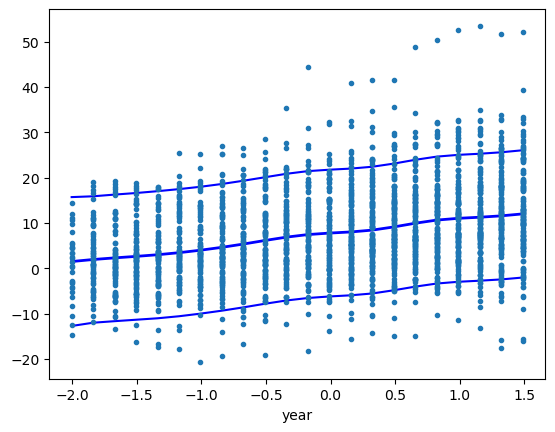

In [15]:
## Year
resgam.plot_partial(0, cpr = True)
plt.show()

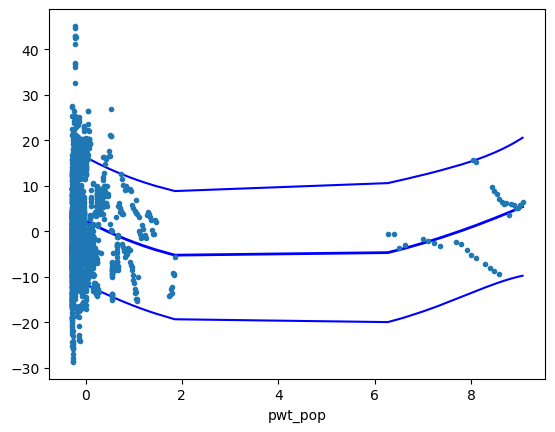

In [16]:
## Population
resgam.plot_partial(1, cpr = True)
plt.show()

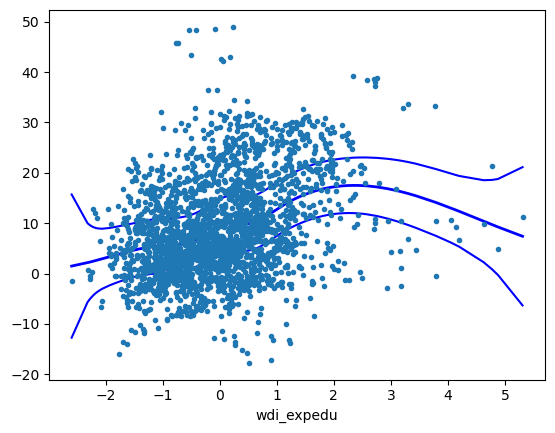

In [17]:
## Expenditure in education
resgam.plot_partial(2, cpr = True)
plt.show()

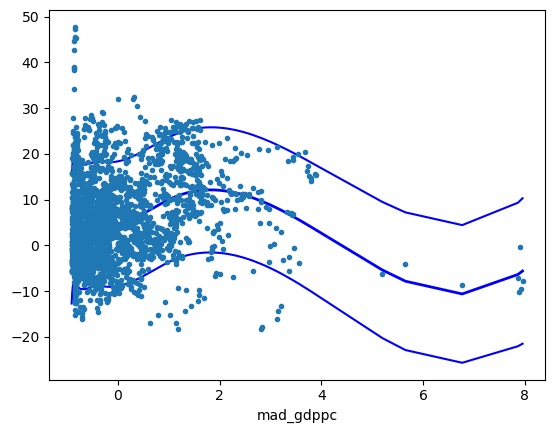

In [18]:
## GDP per capita
resgam.plot_partial(3, cpr = True)
plt.show()

# Questions?

# See you next class


# Extra

## Smoothing Splines

- So far, we define a set of knots, whether we want a natural or regular spline, and fit the coefficients using least squares.

- Another approach that looks much like Lasso or Ridge is the *smoothing splines*.

## Smoothing Splines

- Let a function $g(x)$, we want the function to minimize the $\text{RSS} = \sum (y_i - g(x_i))^2$. 

- The problem is that we can choose $g$ as a cubic spline with as many knots as points: $\text{RSS} = 0$!

- However, we can add a penalty requiring the function to be smooth. We then minimize the following:

$$ \sum_{i=1}^n (y_i - g(x_i))^2 + \alpha \int g''(t)^2dt $$

## Smoothing Splines

- $\int g''(t)^2dt$ measures the amount of wiggling that the function $g$ will do.

- $\alpha = 0$: You could have a polynomial that interpolates every point.
    + $\text{RSS} = 0$, zero bias, lots of variance.

- $\alpha \rightarrow \infty$: Straight line.

## Smoothing Splines

- Interesting: $\alpha$ indirectly controls the degrees of freedom!

- Effective degrees of freedom: One can determine the fitted values by using the following decomposition:

$$ \hat{\bf{g}}_\alpha = \bf{S}_\alpha\bf{y} $$

- The effective number of degrees of freedom will be:

$$ \text{df}_\alpha \ = \ \text{tr}(\bf{S}_\alpha) $$

## Smoothing Splines

- And to find $\alpha$, cross-validation here is very effective. The LOOCV for this case is:

$$ \text{RSS}_{cv} \ = \ \sum_{i=1}^n (y_i - \hat{g}_\alpha^{(-i)}(x_i))^2  \ = \ \sum_{i=1}^n \left[\dfrac{y_i - \hat{g}_\alpha(x_i)}{1-\{\bf{S}_\alpha\}_{ii}}\right]^2 $$

## Smoothing Splines

![img](../img/smspl1.png)

## Local Regression

- Fitting a non-linear flexible function only on points around a place of interest.

- The figure below shows local regressions around 0.05 and 0.4.

![img](../img/loclinreg1.png)

## Local Regression

**Algorithm**: To fit a local regression around $x_0$:

1. Gather the fraction $s = k/n$ of training points whose $x_i$ are closest to $x_0$.

2. Assign a weight $K_{i0} = K(x_i, x_0)$ to each point in this neighborhood so that the point furthest from $x_0$ has weight zero, and the closest has the highest weight. All but these $k$ nearest neighbors get weight zero.

3. Fit a weighted least squares regression of the $y_i$ on the $x_i$ using the aforementioned weights, by finding $\hat{\beta}_0$ and $\hat{\beta}_1$ that minimizes:
$$ \sum_{i=1}^nK_{i0}(y_i - \beta_0 - \beta_1x_i)^2 $$

4. The fitted value at $x_0$ is given by $\hat{f}(x_0) = \hat{\beta}_0 + \hat{\beta}_1x_0$

## Local Regression

- Important choices:

    1. $s$: The share of points we use in the surroundings. The smaller, the lower the bias, and the higher the variance.
    2. If multiple variables, then one can make the model local in some variables and global in others.
    3. Weights are essential!

## Local Regression

![img](../img/loclinreg2.png)